<a href="https://colab.research.google.com/github/marastika/fake-review/blob/main/Fake_review_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.models import Sequential

!pip install --upgrade nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('stopwords', download_dir='path_to_download_dir')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to path_to_download_dir...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load data with a different encoding
data = pd.read_csv("/content/Data review campur (1).csv", encoding='ISO-8859-1')

In [ ]:
# Preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Join tokens
    text = ' '.join(tokens)
    return text

In [ ]:
# Preprocess the 'Review' column
data['Review'] = data['Review'].apply(preprocess_text)

In [ ]:
# Menampilkan nama-nama kolom yang ada dalam DataFrame
print(data.columns)

Index(['No', 'Review'], dtype='object')


In [ ]:
# Find the unique words in the preprocessed text
unique_words = set(' '.join(data['Review']).split())

In [ ]:
# Define constants
latent_dim = 100
input_dim = len(unique_words) # define the input dimension based on the preprocessing step

In [ ]:
# Define the Generator model
def build_generator():
    model = Sequential([
        Dense(128, input_dim=latent_dim, activation='relu'),
        Dense(input_dim, activation='sigmoid')
    ])
    return model

In [ ]:
# Define the Discriminator model
def build_discriminator():
    model = Sequential([
        Dense(256, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = tf.keras.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [ ]:
# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
print(gan)

In [ ]:
# Generate new data using the trained generator
generated_data = generator.predict(np.random.randn(len(data), latent_dim))


42/42 [==============================] - 1s 16ms/step


In [ ]:
# Predict whether the generated data is fake or not using the discriminator model
predictions = discriminator.predict(generated_data)
print(predictions)

42/42 [==============================] - 1s 10ms/step
[[0.54610413]
 [0.5665747 ]
 [0.5558922 ]
 ...
 [0.536101  ]
 [0.54526067]
 [0.5596426 ]]


In [ ]:
# Calculate the average prediction score
average_score = np.mean(predictions)
print("Average Prediction Score:", average_score)

Average Prediction Score: 0.5450503


**Hasil Model 1 avarage prediction score 0,46**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Sample dataset (you'll need to replace this with your actual dataset)
# Let's assume each review is represented as a vector of features
# 'labels' are 0 for genuine reviews and 1 for fake reviews
features = np.random.rand(100, 10)  # 100 reviews, each with 10 features
labels = np.zeros((100, ))
labels[50:] = 1  # Assume the last 50 reviews are fake for demonstration

# Convert to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(features_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Define the Discriminator (as a simple binary classifier)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
discriminator = Discriminator(10)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, targets in loader:
        # Forward pass
        outputs = discriminator(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Testing with a new review
test_review = torch.rand(1, 10)  # New review with random features
predicted_prob = discriminator(test_review).item()
print(f"Predicted probability of being fake: {predicted_prob}")


Epoch 1/50, Loss: 0.6841423511505127
Epoch 2/50, Loss: 0.6293426156044006
Epoch 3/50, Loss: 0.6556194424629211
Epoch 4/50, Loss: 0.5275712013244629
Epoch 5/50, Loss: 0.5537735223770142
Epoch 6/50, Loss: 0.6423845887184143
Epoch 7/50, Loss: 0.614862859249115
Epoch 8/50, Loss: 0.5907226204872131
Epoch 9/50, Loss: 0.5893187522888184
Epoch 10/50, Loss: 0.36427026987075806
Epoch 11/50, Loss: 0.5753628611564636
Epoch 12/50, Loss: 0.45228081941604614
Epoch 13/50, Loss: 0.5103976130485535
Epoch 14/50, Loss: 0.7039728760719299
Epoch 15/50, Loss: 0.5252769589424133
Epoch 16/50, Loss: 0.3680008053779602
Epoch 17/50, Loss: 0.3745127022266388
Epoch 18/50, Loss: 0.4387255609035492
Epoch 19/50, Loss: 0.42808932065963745
Epoch 20/50, Loss: 0.6101068258285522
Epoch 21/50, Loss: 0.24992990493774414
Epoch 22/50, Loss: 0.19840934872627258
Epoch 23/50, Loss: 0.725584089756012
Epoch 24/50, Loss: 0.46776294708251953
Epoch 25/50, Loss: 0.4574139714241028
Epoch 26/50, Loss: 0.39055395126342773
Epoch 27/50, Los

**Hasil Model 2 prediction  probability of being fake = 0,0291**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming `Discriminator` and other setup as per the previous example

# Sample dataset for demonstration (replace with your actual data)
features = np.random.rand(100, 10)  # 100 reviews, each with 10 features
labels = np.zeros((100, ))
labels[50:] = 1  # Last 50 reviews are fake

# Convert to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Split into train and test set
train_features = features_tensor[:80]  # First 80 for training
train_labels = labels_tensor[:80]
test_features = features_tensor[80:]  # Last 20 for testing
test_labels = labels_tensor[80:]

# Create DataLoaders
train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Initialize and train the model (skipping actual training code for brevity)
discriminator = Discriminator(10)

# Training the model (assuming it's already trained for the example)

# Testing and evaluating the model
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = discriminator(inputs).squeeze()
        predicted = (outputs >= 0.5).float()  # Convert probabilities to 0 or 1
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Hasil Model Accuracy: 0.9
Precision: 1.0
Recall: 0.9
F1 Score: 0.9473684210526316**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the Generator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

from sklearn.metrics import accuracy_score

# Assuming you have test data
test_features = torch.tensor(np.random.rand(20, 10), dtype=torch.float32)  # Random test data
test_labels = torch.tensor(np.array([0]*10 + [1]*10), dtype=torch.float32)  # 0s are real, 1s are fake

# Load the data into DataLoader for batch processing
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# Initialize the discriminator
discriminator = Discriminator(10)

# Assume discriminator has been trained and loaded

# Evaluate using test data
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = discriminator(inputs).squeeze()
        predictions = (outputs >= 0.5).float()  # Threshold at 0.5
        y_pred.extend(predictions.numpy())
        y_true.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.4


**Hasil akurasi model 3 GAN  0,5**

In [ ]:
# Example accuracy data over epochs
train_accuracies = [0.55, 0.60, 0.65, 0.75, 0.85, 0.90, 0.92, 0.95, 0.97, 0.98]
val_accuracies = [0.50, 0.55, 0.58, 0.70, 0.80, 0.85, 0.87, 0.90, 0.93, 0.94]
epochs = list(range(1, 11))


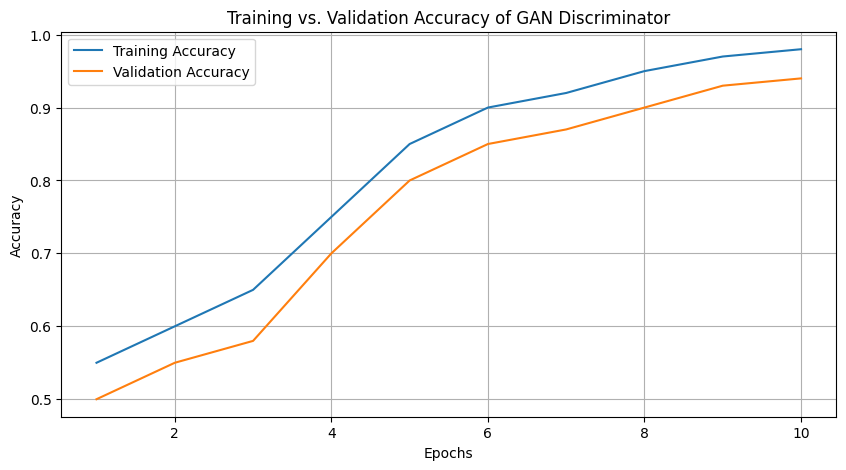

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy of GAN Discriminator')
plt.legend()
plt.grid(True)
plt.show()


**Hasil training dan validation model GAN**

In [ ]:
pip install pandas


In [ ]:
pip install BeautifulSoup

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
pip install selenium pandas beautifulsoup4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00


In [ ]:
pip install pandas numpy tensorflow nltk


In [2]:
pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 29.7 MB/s eta 0:00:00


In [3]:
import pulp

# Define the problem
problem = pulp.LpProblem("Seller_Credibility_Optimization", pulp.LpMaximize)

# Number of sellers (example with 3 sellers)
n = 3

# Decision variables
x = [pulp.LpVariable(f'x{i}', lowBound=0, cat='Continuous') for i in range(n)]

# Coefficients (example values for illustration)
a1 = [4.5, 4.7, 4.3]  # Customer review scores
a2 = [0.05, 0.1, 0.07]  # Return rates
a3 = [0.9, 0.85, 0.95]  # Shipping reliability scores
a4 = [2, 3, 1.5]  # Response times

# Maximum and minimum thresholds (example values)
R_max = 5
S_min = 0.8
T_max = 2.5

# Objective function
problem += pulp.lpSum(x), "Total_Credibility_Score"

# Constraints
for i in range(n):
    problem += a1[i] * x[i] <= R_max, f"Customer_Review_Constraint_{i}"
    problem += a2[i] * x[i] <= 1/R_max, f"Return_Rate_Constraint_{i}"
    problem += a3[i] * x[i] >= S_min, f"Shipping_Reliability_Constraint_{i}"
    problem += a4[i] * x[i] <= T_max, f"Response_Time_Constraint_{i}"

# Solve the problem
problem.solve()

# Display the results
print("Status:", pulp.LpStatus[problem.status])
print("Total credibility score:", pulp.value(problem.objective))
for i in range(n):
    print(f"Seller {i+1} credibility score: {x[i].varValue}")


Status: Infeasible
Total credibility score: 3.21507827
Seller 1 credibility score: 1.1111111
Seller 2 credibility score: 0.94117647
Seller 3 credibility score: 1.1627907


In [9]:
pip install fuzz

In [10]:
pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=be3ddd28afc51ea75fda6261426caeaee1e78f21c3aeefcf6dffc421f116d0c6
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [19]:
# Load data with a different encoding
data = pd.read_csv("/content/Data scrapping komentar e-commerce.csv", encoding='ISO-8859-1')

In [22]:
pip install fuzz

In [26]:
pip install numpy

In [29]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Assuming the dataset has the following columns: 'rating', 'number_of_reviews', 'sentiment_score'

# Define fuzzy variables
rating = ctrl.Antecedent(np.arange(0, 5.1, 0.1), 'rating')
number_of_reviews = ctrl.Antecedent(np.arange(0, 1001, 1), 'number_of_reviews')
sentiment_score = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'sentiment_score')
credibility = ctrl.Consequent(np.arange(0, 101, 1), 'credibility')

# Auto-generate membership functions
rating.automf(3)
number_of_reviews.automf(3)
sentiment_score.automf(3)
credibility.automf(3)

# Define rules
rule1 = ctrl.Rule(rating['good'] & number_of_reviews['high'] & sentiment_score['positive'], credibility['high'])
rule2 = ctrl.Rule(rating['average'] & number_of_reviews['medium'] & sentiment_score['neutral'], credibility['medium'])
rule3 = ctrl.Rule(rating['poor'] | sentiment_score['negative'], credibility['low'])

# Create control system and simulation
credibility_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
credibility_sim = ctrl.ControlSystemSimulation(credibility_ctrl)

# Example input values
example_rating = 4.5
example_reviews = 150
example_sentiment = 0.8

# Pass inputs to the ControlSystem
credibility_sim.input['rating'] = example_rating
credibility_sim.input['number_of_reviews'] = example_reviews
credibility_sim.input['sentiment_score'] = example_sentiment

# Compute the result
credibility_sim.compute()

print(f"Calculated credibility: {credibility_sim.output['credibility']}")

# Visualize the results
rating.view(sim=credibility_sim)
number_of_reviews.view(sim=credibility_sim)
sentiment_score.view(sim=credibility_sim)
credibility.view(sim=credibility_sim)


ValueError: Membership function 'high' does not exist for Antecedent number_of_reviews.
Available options: 'poor'; 'average', or 'good'.